In [1]:
import torch, torchvision
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.set_printoptions(sci_mode=False, precision=4)
import torchvision.ops as ops

import numpy as np
np.random.seed(0)

from darknet2pytorch import *

from PIL import Image, ImageDraw

In [2]:
model = darknet.Darknet("./cfg/yolov4.cfg").cuda()
model.load_weights('e:/weights/darknet/yolov4.weights')
img_size = (608,608)

In [3]:
def post_processing(output, thres_conf=0.5, thres_nms=0.5):
    #do nms
    result = []
    # print(output.shape)
    for i, pred in enumerate(output):
        #print(pred.shape) #torch.Size([10647, 85])
        pred = pred[pred[:, 4] > thres_conf]
        # if pred.nelement() == 0:
        #     continue
        # print(pred.shape)
        x_min = (pred[:, 0:1] - pred[:, 2:3] / 2.0)
        y_min = (pred[:, 1:2] - pred[:, 3:4] / 2.0)
        x_max = (pred[:, 0:1] + pred[:, 2:3] / 2.0)
        y_max = (pred[:, 1:2] + pred[:, 3:4] / 2.0)

        pred_xyxy = torch.cat((x_min, y_min, x_max, y_max), dim=1)
        pred_score, pred_cls_idx = torch.max(pred[:, 5:], 1, keepdim=True)

        keep = ops.boxes.batched_nms(pred_xyxy, pred_score[:, 0],
                                     pred_cls_idx[:, 0], thres_nms)
        pred = torch.cat((pred_xyxy, pred_score, pred_cls_idx.float()),
                         1)[keep]

        batch_num = (torch.ones(pred.shape[0], 1) * i).cuda()
        pred = torch.cat((pred, batch_num), dim=1)
        result.append(pred)

    if not result:
        return torch.zeros(1, 7).fill_(255)
    else:
        return torch.cat(result, dim=0)

In [12]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
# t = torchvision.transforms.Compose([torchvision.transforms.Resize(img_size),
#                                     torchvision.transforms.ToTensor(),
#                                     torchvision.transforms.Normalize(mean,std)])
t = torchvision.transforms.Compose([torchvision.transforms.Resize(img_size),
                                    torchvision.transforms.ToTensor()])

In [13]:
def load_classes(path):
    #Loads class labels at 'path'
    fp = open(path, "r")
    return fp.read().split("\n")[:-1]
classes = load_classes("./data/coco_names.txt")
def draw_boxes(img, boxes, conf, cls):
    #img : PIL Image
    #boxes : N x 4, (x_min,y_min, x_max,y_max)
    #conf : N, confidence score
    #cls :  N, class number
    box_img = ImageDraw.Draw(img)
    
    for box, conf_, cls_ in zip(boxes.cpu(), conf.cpu(), cls.cpu()):
        box_img.rectangle(list(box.data), outline="red")
        box_img.text((box[0], box[1]), classes[int(cls_)], (255,0,0))
    return img

In [14]:
model.eval()

Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (mish_0): Mish()
    )
    (1): Sequential(
      (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (mish_1): Mish()
    )
    (2): Sequential(
      (conv_2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batch_norm_2): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (mish_2): Mish()
    )
    (3): Sequential(
      (route_3): EmptyLayer()
    )
    (4): Sequential(
      (conv_4): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batch_norm_4): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_run

In [21]:
img1 = Image.open("./imgs/giraffe.jpg")
# img1 = Image.open("e:/test3.jpg")

t_img1 = t(img1).unsqueeze(0).cuda()
img1 = img1.resize(img_size)
with torch.no_grad():
    out = model(t_img1)
print(out[0][out[0,:,4]>0.1][0:, :5])

out_ = post_processing(out)

Sequential(
  (yolo_layer_139): DarknetYOLOLayer()
)
Sequential(
  (yolo_layer_150): DarknetYOLOLayer()
)
Sequential(
  (yolo_layer_161): DarknetYOLOLayer()
)
tensor([[  410.2680,   381.2963,   219.7500,   289.5118,     0.7581],
        [  408.8797,   395.5555,   218.8311,   300.5376,     0.9852],
        [  418.9447,   395.7192,   209.9487,   294.7308,     0.7078],
        [  369.4515,   250.3628,   337.7918,   444.7126,     0.3411],
        [  349.2162,   278.4909,   331.7515,   489.2436,     0.4360],
        [  366.4009,   279.3006,   334.1434,   494.9427,     0.9953],
        [  389.7399,   275.4116,   385.2438,   481.5407,     0.6323],
        [  349.1019,   292.7910,   351.7927,   535.6463,     0.1733],
        [  363.6888,   293.8158,   334.2851,   515.2578,     0.9834],
        [  409.9787,   381.3286,   219.8574,   293.5498,     0.7961],
        [  408.7311,   395.3598,   218.4678,   299.4402,     0.9877],
        [  418.9955,   395.6868,   210.2320,   296.0033,     0.7494],
 

In [22]:
imgs = [img1]
imgs[0] = draw_boxes(imgs[0], out_[:, :4], out_[:, 4], out_[:, 5])

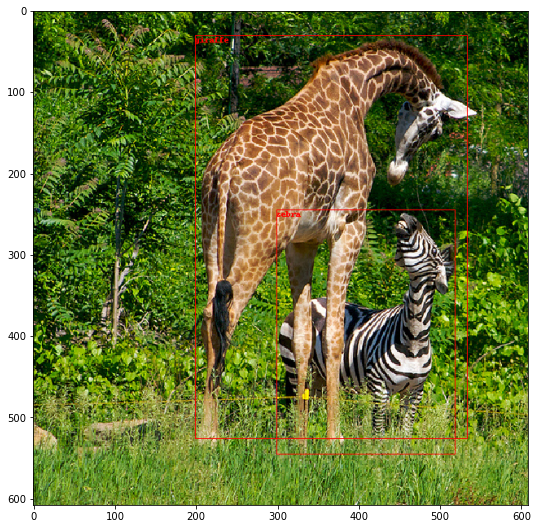

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(imgs[0])